In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.animation as animation
from sklearn import linear_model

In [2]:
def Solve_RK4(t, X_initial, func_ODEs, h):
    n = t.shape[0]
    X = X_initial

    for i in range(n-1):
        
        midt = t[i] + 0.5*h

        k1 = func_ODEs(t[i], X)

        midX1 = X + k1*0.5*h
        k2 = func_ODEs(midt, midX1)

        midX2 = X + k2*0.5*h
        k3 = func_ODEs(midt, midX2)

        X3 = X + k3*h
        k4 = func_ODEs(t[i+1], X3)

        X = X + (k1 + 2*k2 + 2*k3 + k4)*h/6

    return X

def func_ODEs(t, X):
    x = X[0, :]
    rho = X[1, :]
    dx_dt = x - x**3
    drho_dt = -rho*(1 - 3*x**2)
    ODEs = np.array([dx_dt, drho_dt])

    return ODEs

def PDF(x, mu, std):
    return stats.norm(mu, std).pdf(x)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ===========================================
# Define network
# ===========================================
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, output_size),
            nn.Identity()
        )

    def forward(self, x):
        return self.net(x)

def train(model, x, y, optimizer):
    x, y = x.to(device), y.to(device)
    model.train()
    model.zero_grad()
    output = model(x).squeeze()
    loss = F.mse_loss(output, y)
    loss.backward()
    optimizer.step()
    return loss.item(), output

def test(model, x, y):
    x, y = x.to(device), y.to(device)
    model.eval()
    with torch.no_grad():
        output = model(x).squeeze()
        loss = F.mse_loss(output, y)
    return loss.item(), output

In [4]:
mu = 0
sigma = 1

t = np.arange(0, 2.04, 0.02)
x_ini = np.arange(-3.14, 3.14, 0.01)
rho_ini = PDF(x_ini, mu, sigma)

h = t[1] - t[0]
nt = t.shape[0]
m = x_ini.shape[0]

x_nume = np.zeros((nt, m))
rho_nume = np.zeros((nt, m))

In [5]:
x_nume[0, :] = x_ini
rho_nume[0, :] = rho_ini
ini_array = np.array([x_ini, rho_ini])

for i in range(nt-1):
    x_nume[i+1, :] = Solve_RK4(t[i:i+2], ini_array, func_ODEs, h)[0, :]
    rho_nume[i+1, :] = Solve_RK4(t[i:i+2], ini_array, func_ODEs, h)[1, :]
    ini_array = np.array([x_nume[i+1, :], rho_nume[i+1, :]])

f_x_nume = (x_nume[1:, :] - x_nume[:-1, :]) / h

In [6]:
# ===========================================
# Data loading and splitting
# ===========================================

x_nume_DNN = x_nume[:4, :].reshape(-1, 1)
f_x_nume_DNN = f_x_nume[:4, :].reshape(-1, 1)

# train/valid split
x_train, x_valid, y_train, y_valid = train_test_split(x_nume_DNN, f_x_nume_DNN, test_size=0.25, random_state=42)

# convert to tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float().squeeze()
x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float().squeeze()

In [7]:
# ===========================================
# Model settings and training
# ===========================================
input_size  = 1
output_size = 1
EPOCHS = 5000
lr = 0.001
wd = 0.1

model = DeepNeuralNetwork(input_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                                
Loss = np.zeros((EPOCHS, 2))    # train, valid

for epoch in range(EPOCHS):
    train_loss, train_pred = train(model, x_train, y_train, optimizer)

    valid_loss, valid_pred = test(model, x_valid, y_valid)

    Loss[epoch, :] = [train_loss, valid_loss]

    print("Epoch %d: Training MSE = %.6f, Validation MSE = %.6f" %(epoch+1, train_loss, valid_loss))

Epoch 1: Training MSE = 34.899292, Validation MSE = 30.176090
Epoch 2: Training MSE = 34.887924, Validation MSE = 30.165407
Epoch 3: Training MSE = 34.877010, Validation MSE = 30.155062
Epoch 4: Training MSE = 34.866409, Validation MSE = 30.144766
Epoch 5: Training MSE = 34.856022, Validation MSE = 30.134840
Epoch 6: Training MSE = 34.845833, Validation MSE = 30.125462
Epoch 7: Training MSE = 34.836048, Validation MSE = 30.116621
Epoch 8: Training MSE = 34.826736, Validation MSE = 30.108162
Epoch 9: Training MSE = 34.817612, Validation MSE = 30.099810
Epoch 10: Training MSE = 34.808685, Validation MSE = 30.091835
Epoch 11: Training MSE = 34.800159, Validation MSE = 30.085169
Epoch 12: Training MSE = 34.793034, Validation MSE = 30.079149
Epoch 13: Training MSE = 34.786476, Validation MSE = 30.073038
Epoch 14: Training MSE = 34.779846, Validation MSE = 30.066816
Epoch 15: Training MSE = 34.773125, Validation MSE = 30.060461
Epoch 16: Training MSE = 34.766300, Validation MSE = 30.053967
E

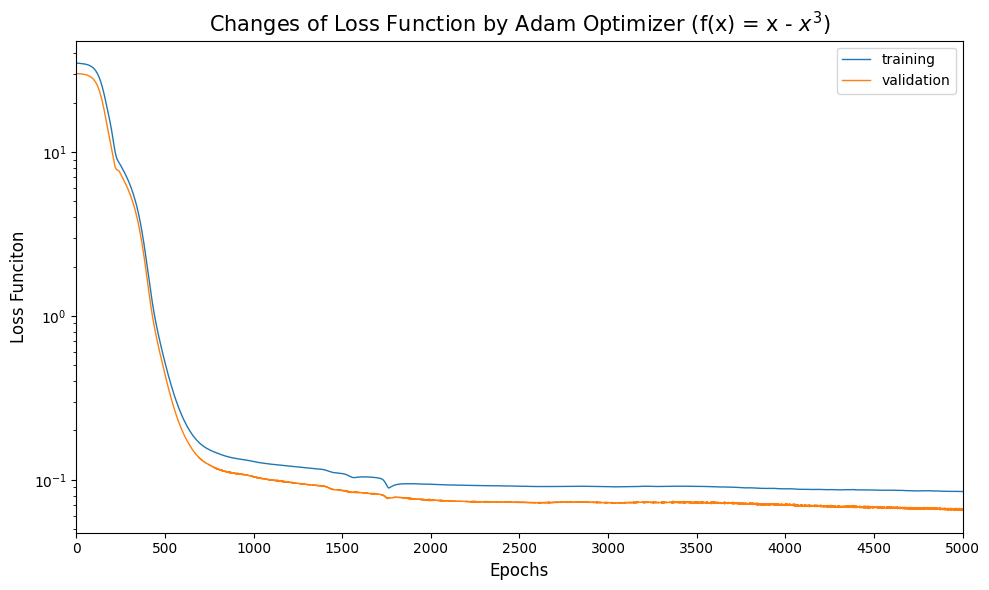

In [8]:
# ===========================================
# Plot results
# ===========================================
plt.figure(figsize=(10, 6))

plt.yscale('log')
plt.plot(np.arange(1, EPOCHS+1), Loss[:, 0], lw=1, label='training')
plt.plot(np.arange(1, EPOCHS+1), Loss[:, 1], lw=1, label='validation')
plt.xticks(np.linspace(0, EPOCHS, 11))
plt.xlim([0, EPOCHS])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Funciton', fontsize=12)
plt.title('Changes of Loss Function by Adam Optimizer (f(x) = x - $x^{3}$)', fontsize=15)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('f_x_DNN_loss_func.png', dpi=500)
plt.show()

In [9]:
x_test_0 = np.arange(-np.pi, np.pi, 0.01)

m2 = x_test_0.shape[0]
x_DNN = np.zeros((nt, m2))
f_x_DNN = np.zeros((nt, m2))

x_ini = x_test_0
rho_ini = PDF(x_ini, mu, sigma)
ini_array = np.array([x_ini, rho_ini])
x_test_1 = Solve_RK4(t[0:2], ini_array, func_ODEs, h)[0, :]

x_test = x_test_0.reshape(-1, 1)
y_test = ((x_test_1 - x_test_0) / h).reshape(-1, 1)

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float().squeeze()

test_loss, test_pred = test(model, x_test, y_test)

x_DNN[0, :] = x_test.squeeze().cpu()
f_x_DNN[0, :] = test_pred.cpu()

for i in range(nt-2):
    x_DNN[i+1, :] = x_DNN[i, :] + f_x_DNN[i, :]*h
    x_ini = x_DNN[i+1, :]
    rho_ini = PDF(x_ini, mu, sigma)
    ini_array = np.array([x_ini, rho_ini])
    x_fin = Solve_RK4(t[i+1:i+3], ini_array, func_ODEs, h)[0, :]

    x_test = x_ini.reshape(-1, 1)
    y_test = ((x_fin - x_ini) / h).reshape(-1, 1)

    x_test = torch.tensor(x_test).float()
    y_test = torch.tensor(y_test).float().squeeze()

    test_loss, test_pred = test(model, x_test, y_test)

    x_DNN[i+1, :] = x_test.squeeze().cpu()
    f_x_DNN[i+1, :] = test_pred.cpu()

x_DNN[-1, :] = x_DNN[-2, :] + f_x_DNN[-2, :]*h

C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\3724773972.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_DNN[0, :] = x_test.squeeze().cpu()
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\3724773972.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  f_x_DNN[0, :] = test_pred.cpu()
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\3724773972.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_DNN[i+1, :] = x_test.squeeze().cpu()
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\3724773972.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __arr

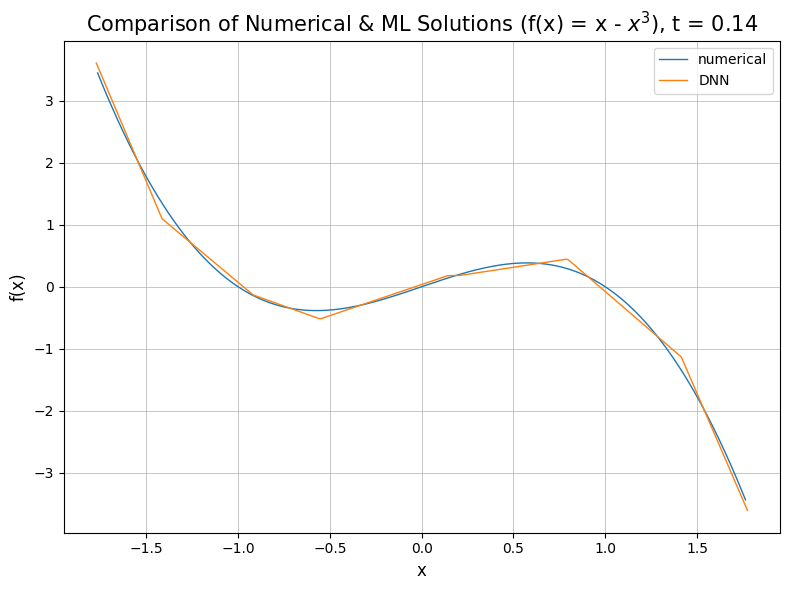

In [10]:
step = 7

plt.figure(figsize=(8, 6))
# 
plt.plot(x_nume[step, :], f_x_nume[step, :], lw=1, label='numerical')
plt.plot(x_DNN[step, :], f_x_DNN[step, :], lw=1, label='DNN')
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.title('Comparison of Numerical & ML Solutions (f(x) = x - $x^{3}$), t = %.2f' %t[step], fontsize=15)
plt.legend(loc='upper right', fontsize=10)

plt.grid(lw=0.5)
plt.tight_layout()
plt.savefig('f_x_comparison.png', dpi=500)
plt.show()

In [11]:
def cen_diff(x, h):
    return (-x[4:, :] + 8*x[3:-1, :] - 8*x[1:-3, :] + x[:-4, :]) / (12*h)
def par_for_diff(x, h):
    return (-x[4, :] + 6*x[3, :] - 18*x[2, :] + 10*x[1, :] + 3*x[0, :]) / (12*h)
def for_diff(x, h):
    return (-25*x[0, :] + 48*x[1, :] - 36*x[2, :] + 16*x[3, :] - 3*x[4, :]) / (12*h)
def par_back_diff(x, h):
    return (x[-5, :] - 6*x[-4, :] + 18*x[-3, :] - 10*x[-2, :] - 3*x[-1, :]) / (12*h)
def back_diff(x, h):
    return (25*x[-1, :] - 48*x[-2, :] + 36*x[-3, :] - 16*x[-4, :] + 3*x[-5, :]) / (12*h)

In [12]:
x_DNN_temp = (x_DNN[1:, :] + x_DNN[:-1, :]) / 2

In [13]:
G = np.zeros((nt-1, m2, input_size, input_size))

for i in range(nt-1):
    for j in range(m2):
        if input_size == 1:
            Ga = np.dot(x_DNN[i+1, j], x_DNN[i, j].transpose())
            Gb = np.linalg.inv(np.array([[np.dot(x_DNN[i, j], x_DNN[i, j].transpose())]]))
            G[i, j, :, :] = np.dot(Ga, Gb)
        else:
            Ga = np.dot(x_DNN[i+1, j], x_DNN[i, j].transpose())
            Gb = np.linalg.inv(np.dot(x_DNN[i, j], x_DNN[i, j].transpose()))
            G[i, j, :, :] = np.dot(Ga, Gb)

f_div = np.zeros((nt-1, m2))

f_div[2:-2, :] = cen_diff(np.log(np.linalg.det(G)), h)
f_div[0, :] = for_diff(np.log(np.linalg.det(G)), h)
f_div[1, :] = par_for_diff(np.log(np.linalg.det(G)), h)
f_div[-1, :] = back_diff(np.log(np.linalg.det(G)), h)
f_div[-2, :] = par_back_diff(np.log(np.linalg.det(G)), h)

C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\4262512725.py:16: RuntimeWarning: invalid value encountered in log
  f_div[2:-2, :] = cen_diff(np.log(np.linalg.det(G)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\4262512725.py:17: RuntimeWarning: invalid value encountered in log
  f_div[0, :] = for_diff(np.log(np.linalg.det(G)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\4262512725.py:18: RuntimeWarning: invalid value encountered in log
  f_div[1, :] = par_for_diff(np.log(np.linalg.det(G)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\4262512725.py:19: RuntimeWarning: invalid value encountered in log
  f_div[-1, :] = back_diff(np.log(np.linalg.det(G)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\4262512725.py:20: RuntimeWarning: invalid value encountered in log
  f_div[-2, :] = par_back_diff(np.log(np.linalg.det(G)), h)


In [14]:
G_temp = np.zeros((nt-2, m2, input_size, input_size))

for i in range(nt-2):
    for j in range(m2):
        if input_size == 1:
            Ga = np.dot(x_DNN_temp[i+1, j], x_DNN_temp[i, j].transpose())
            Gb = np.linalg.inv(np.array([[np.dot(x_DNN_temp[i, j], x_DNN_temp[i, j].transpose())]]))
            G_temp[i, j, :, :] = np.dot(Ga, Gb)
        else:
            Ga = np.dot(x_DNN_temp[i+1, j], x_DNN_temp[i, j].transpose())
            Gb = np.linalg.inv(np.dot(x_DNN_temp[i, j], x_DNN_temp[i, j].transpose()))
            G_temp[i, j, :, :] = np.dot(Ga, Gb)

f_div_temp = np.zeros((nt-2, m2))

f_div_temp[2:-2, :] = cen_diff(np.log(np.linalg.det(G_temp)), h)
f_div_temp[0, :] = for_diff(np.log(np.linalg.det(G_temp)), h)
f_div_temp[1, :] = par_for_diff(np.log(np.linalg.det(G_temp)), h)
f_div_temp[-1, :] = back_diff(np.log(np.linalg.det(G_temp)), h)
f_div_temp[-2, :] = par_back_diff(np.log(np.linalg.det(G_temp)), h)

C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\2778757435.py:16: RuntimeWarning: invalid value encountered in log
  f_div_temp[2:-2, :] = cen_diff(np.log(np.linalg.det(G_temp)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\2778757435.py:17: RuntimeWarning: invalid value encountered in log
  f_div_temp[0, :] = for_diff(np.log(np.linalg.det(G_temp)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\2778757435.py:18: RuntimeWarning: invalid value encountered in log
  f_div_temp[1, :] = par_for_diff(np.log(np.linalg.det(G_temp)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\2778757435.py:19: RuntimeWarning: invalid value encountered in log
  f_div_temp[-1, :] = back_diff(np.log(np.linalg.det(G_temp)), h)
C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\2778757435.py:20: RuntimeWarning: invalid value encountered in log
  f_div_temp[-2, :] = par_back_diff(np.log(np.linalg.det(G_temp)), h)


In [15]:
rho_DNN = np.zeros((nt-1, m2))

rho_DNN[0, :] = PDF(x_DNN[0, :], mu, sigma)

drho_dt = lambda rho, f_div: -rho*f_div

for i in range(nt-2):
    midt = t[i] + 0.5*h

    k1 = drho_dt(rho_DNN[i, :], f_div[i, :])

    midrho1 = rho_DNN[i, :] + k1*0.5*h
    k2 = drho_dt(midrho1, f_div_temp[i, :])

    midrho2 = rho_DNN[i, :] + k2*0.5*h
    k3 = drho_dt(midrho2, f_div_temp[i, :])

    rho3 = rho_DNN[i, :] + k3*h
    k4 = drho_dt(rho3, f_div[i+1, :])

    rho_DNN[i+1, :] = rho_DNN[i, :] + (k1 + 2*k2 + 2*k3 + k4)*h/6

    mask = ~np.isnan(rho_DNN[i+1, :])
    rho_DNN[i+1, :] = rho_DNN[i+1, :] / np.trapezoid(rho_DNN[i+1, :][mask], x_DNN[i+1, :][mask]) * np.trapezoid(rho_DNN[0, :][mask], x_DNN[0, :][mask])

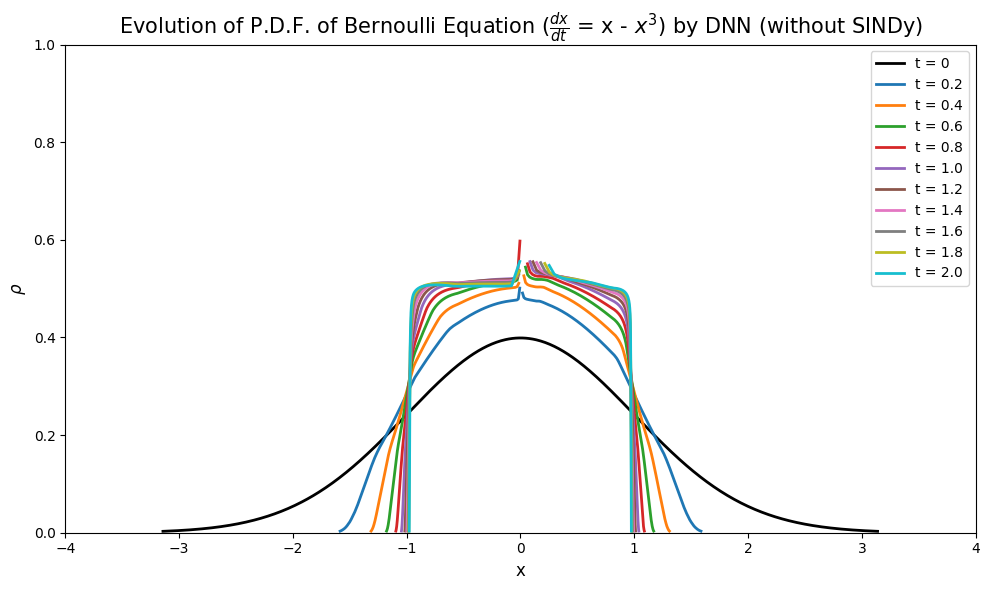

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(x_DNN[0, :], rho_DNN[0, :], color='k', lw=2, label='t = 0')
for i in range(10):
    plt.plot(x_DNN[10*(i+1), :], rho_DNN[10*(i+1), :], lw=2, label='t = %.1f' %(0.2*(i+1)))

plt.xticks(np.linspace(-4, 4, 9))
#plt.yticks()
plt.xlim([-4, 4])
plt.ylim([0, 1])
plt.xlabel('x', fontsize=12)
plt.ylabel(r'$\rho$', fontsize=12)
plt.title(r'Evolution of P.D.F. of Bernoulli Equation ($\frac{dx}{dt}$ = x - $x^{3}$) by DNN (without SINDy)', fontsize=15)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('Bernoulli_rho_DNN.png', dpi=500)
plt.show()

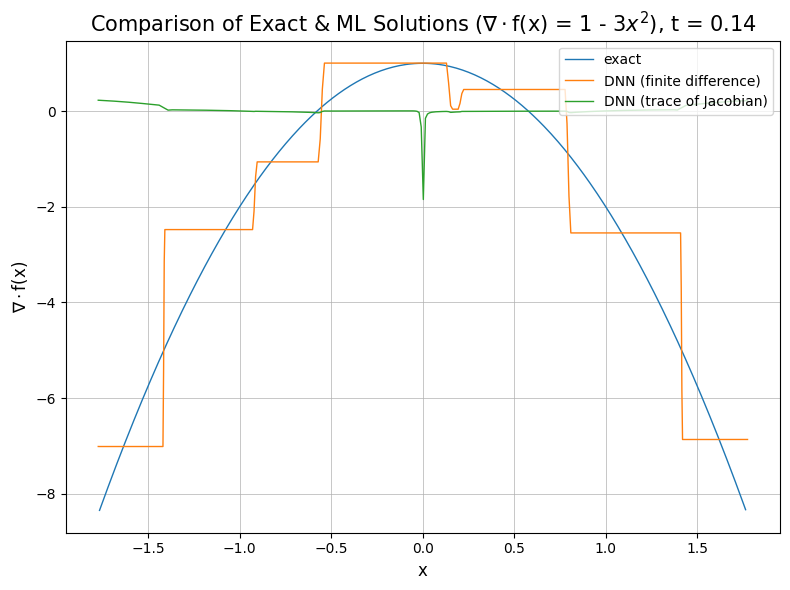

In [17]:
step = 7

plt.figure(figsize=(8, 6))

plt.plot(x_nume[step, :], 1-3*x_nume[step, :]**2, lw=1, label='exact')
plt.plot(x_DNN[step, :], np.gradient(f_x_DNN[step, :], x_DNN[step, :], edge_order=2), lw=1, label='DNN (finite difference)')
plt.plot(x_DNN[step, :], f_div[step, :], lw=1, label='DNN (trace of Jacobian)')
plt.xlabel('x', fontsize=12)
plt.ylabel(r'$\nabla \cdot$f(x)', fontsize=12)
plt.title(r'Comparison of Exact & ML Solutions ($\nabla \cdot$f(x) = 1 - 3$x^{2}$), t = %.2f' %t[step], fontsize=15)
plt.legend(loc='upper right', fontsize=10)

plt.grid(lw=0.5)
plt.tight_layout()
plt.savefig('div_f_x_comparison.png', dpi=500)
plt.show()

In [18]:
f_div_FD = np.zeros((nt-1, m2))

for i in range(nt-1):
    f_div_FD[i, :] = np.gradient(f_x_DNN[i, :], x_DNN[i, :], edge_order=2)

f_div_FD_temp = (f_div_FD[1:, :] + f_div_FD[:-1, :]) / 2

In [19]:
rho_FD_DNN = np.zeros((nt-1, m2))

rho_FD_DNN[0, :] = PDF(x_DNN[0, :], mu, sigma)

drho_dt = lambda rho, f_div: -rho*f_div

for i in range(nt-2):
    midt = t[i] + 0.5*h

    k1 = drho_dt(rho_FD_DNN[i, :], f_div_FD[i, :])

    midrho1 = rho_FD_DNN[i, :] + k1*0.5*h
    k2 = drho_dt(midrho1, f_div_FD_temp[i, :])

    midrho2 = rho_FD_DNN[i, :] + k2*0.5*h
    k3 = drho_dt(midrho2, f_div_FD_temp[i, :])

    rho3 = rho_FD_DNN[i, :] + k3*h
    k4 = drho_dt(rho3, f_div_FD[i+1, :])

    mask = ~np.isnan(rho_FD_DNN[i+1, :])
    rho_FD_DNN[i+1, :] = rho_FD_DNN[i, :] + (k1 + 2*k2 + 2*k3 + k4)*h/6
    rho_FD_DNN[i+1, :] = rho_FD_DNN[i+1, :] / np.trapezoid(rho_FD_DNN[i+1, :][mask], x_DNN[i+1, :][mask]) * np.trapezoid(rho_FD_DNN[0, :][mask], x_DNN[0, :][mask])

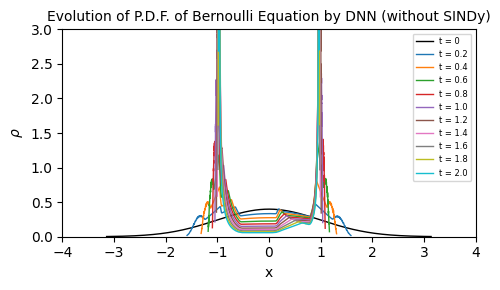

In [33]:
plt.figure(figsize=(5, 3))
plt.plot(x_DNN[0, :], rho_FD_DNN[0, :], color='k', lw=1, label='t = 0')
for i in range(10):
    plt.plot(x_DNN[10*(i+1), :], rho_FD_DNN[10*(i+1), :], lw=1, label='t = %.1f' %(0.2*(i+1)))

plt.xticks(np.linspace(-4, 4, 9))
#plt.yticks()
plt.xlim([-4, 4])
plt.ylim([0, 3])
plt.xlabel('x', fontsize=10)
plt.ylabel(r'$\rho$', fontsize=10)
plt.title('Evolution of P.D.F. of Bernoulli Equation by DNN (without SINDy)', fontsize=10)
plt.legend(loc='upper right', fontsize=6)

plt.tight_layout()
plt.savefig('Bernoulli_rho_DNN_FD.png', dpi=500)
plt.show()

C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\1413457923.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=10)


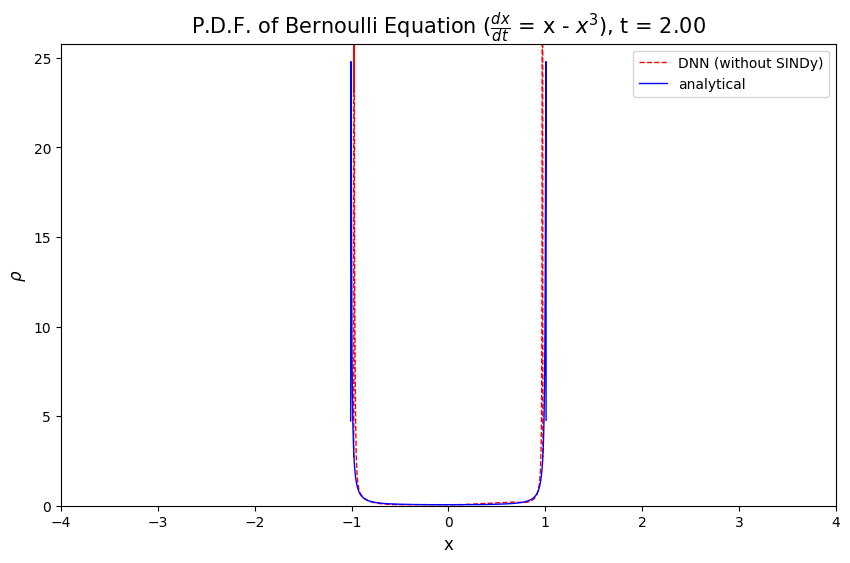

In [21]:
rho_ini = PDF(x_DNN[0, :], mu, sigma)

xx_ini, tt = np.meshgrid(x_DNN[0, :], t)
rhorho_ini, tt = np.meshgrid(rho_ini, t)

x_exact = xx_ini*np.exp(tt)*(1 - xx_ini**2 + (xx_ini**2)*np.exp(2*tt))**(-1/2)
rho_exact = rhorho_ini * (xx_ini - xx_ini**3) / (x_exact - x_exact**3)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xticks(np.linspace(-4, 4, 9))
ax.set_xlim([-4, 4])
ax.set_ylim([0, 2])
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel(r'$\rho$', fontsize=12)
ax.legend(loc='upper right', fontsize=10)

DNN_line, = ax.plot([], [], color='r', ls='--', lw=1, label='DNN (without SINDy)')
analytical_line, = ax.plot([], [], color='b', lw=1, label='analytical')
ax.legend(loc='upper right', fontsize=10)
#plt.tight_layout()

def init():
    DNN_line.set_data(x_DNN[0, :], rho_FD_DNN[0, :])
    analytical_line.set_data(x_exact[0, :], rho_exact[0, :])
    ax.set_title(r'P.D.F. of Bernoulli Equation ($\frac{dx}{dt}$ = x - $x^{3}$),'+' t = %.2f' %t[0], fontsize=15)
    return DNN_line, analytical_line

def update(frame):
    DNN_line.set_data(x_DNN[frame+1, :], rho_FD_DNN[frame+1, :])
    analytical_line.set_data(x_exact[frame+1, :], rho_exact[frame+1, :])
    if np.amax(rho_exact[frame+1, :]) >= 1:
        ax.set_ylim([0, np.amax(rho_exact[frame+1, :])+1])
    ax.set_title(r'P.D.F. of Bernoulli Equation ($\frac{dx}{dt}$ = x - $x^{3}$),'+' t = %.2f' %t[frame+1], fontsize=15)
    return DNN_line, analytical_line

ani = animation.FuncAnimation(fig, update, frames=nt-2, init_func=init, blit=True)

ani.save('Bernoulli_rho_DNN (dt=%.2f).mp4' %h, fps=10, dpi=500)

In [22]:
f_div_SINDy = np.zeros((nt-1, m2))

for i in range(nt-1):
    ##### calculate divergence of f(x) #### 

    # using 5th order polynomial for SINDy bias correction
    x_predictor = np.squeeze(np.array([np.ones(m2), x_DNN[i, :], x_DNN[i, :]**2, x_DNN[i, :]**3, x_DNN[i, :]**4, x_DNN[i, :]**5]))

    if i == 0:  
        clf = linear_model.Lasso(alpha=0.01)
        clf.fit(x_predictor.T, f_div_FD[i, :])

    f_div_SINDy[i, :] = np.dot(clf.coef_.T, x_predictor) + clf.intercept_

f_div_SINDy_temp = (f_div_SINDy[1:, :] + f_div_SINDy[:-1, :]) / 2

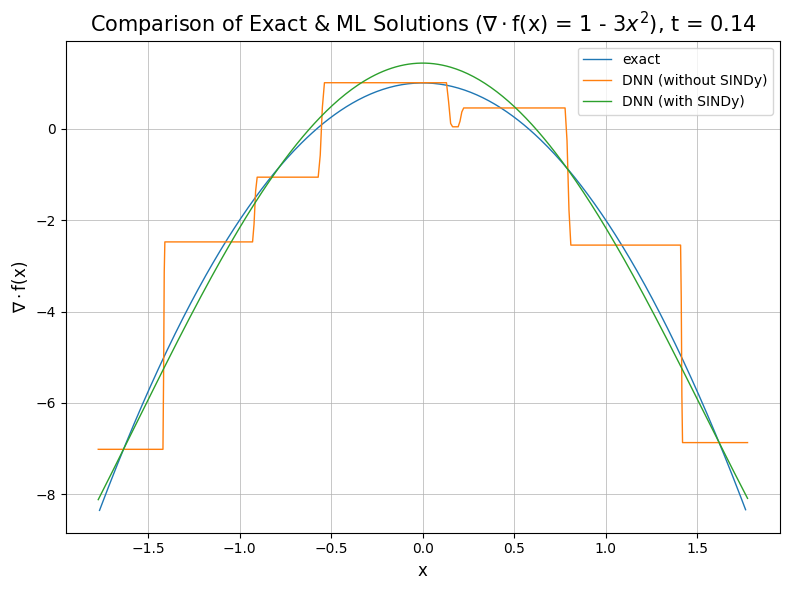

In [23]:
step = 7

plt.figure(figsize=(8, 6))

plt.plot(x_nume[step, :], 1-3*x_nume[step, :]**2, lw=1, label='exact')
plt.plot(x_DNN[step, :], f_div_FD[step, :], lw=1, label='DNN (without SINDy)')
plt.plot(x_DNN[step, :], f_div_SINDy[step, :], lw=1, label='DNN (with SINDy)')
plt.xlabel('x', fontsize=12)
plt.ylabel(r'$\nabla \cdot$f(x)', fontsize=12)
plt.title(r'Comparison of Exact & ML Solutions ($\nabla \cdot$f(x) = 1 - 3$x^{2}$), t = %.2f' %t[step], fontsize=15)
plt.legend(loc='upper right', fontsize=10)

plt.grid(lw=0.5)
plt.tight_layout()
plt.savefig('div_f_x_comparison_SINDy.png', dpi=500)
plt.show()

In [24]:
rho_SINDy_DNN = np.zeros((nt-1, m2))

rho_SINDy_DNN[0, :] = PDF(x_DNN[0, :], mu, sigma)

drho_dt = lambda rho, f_div: -rho*f_div

for i in range(nt-2):
    midt = t[i] + 0.5*h

    k1 = drho_dt(rho_SINDy_DNN[i, :], f_div_SINDy[i, :])

    midrho1 = rho_SINDy_DNN[i, :] + k1*0.5*h
    k2 = drho_dt(midrho1, f_div_SINDy_temp[i, :])

    midrho2 = rho_SINDy_DNN[i, :] + k2*0.5*h
    k3 = drho_dt(midrho2, f_div_SINDy_temp[i, :])

    rho3 = rho_SINDy_DNN[i, :] + k3*h
    k4 = drho_dt(rho3, f_div_SINDy[i+1, :])

    rho_SINDy_DNN[i+1, :] = rho_SINDy_DNN[i, :] + (k1 + 2*k2 + 2*k3 + k4)*h/6
    rho_SINDy_DNN[i+1, :] = rho_SINDy_DNN[i+1, :] / np.trapezoid(rho_SINDy_DNN[i+1, :], x_DNN[i+1, :]) * np.trapezoid(rho_SINDy_DNN[0, :], x_DNN[0, :])

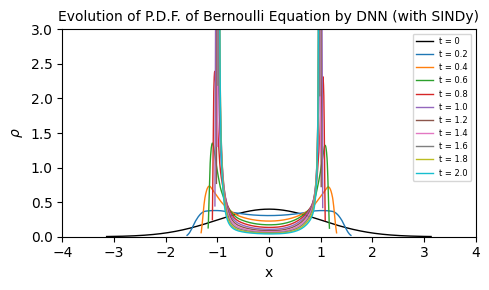

In [32]:
plt.figure(figsize=(5, 3))
plt.plot(x_DNN[0, :], rho_SINDy_DNN[0, :], color='k', lw=1, label='t = 0')
for i in range(10):
    plt.plot(x_DNN[10*(i+1), :], rho_SINDy_DNN[10*(i+1), :], lw=1, label='t = %.1f' %(0.2*(i+1)))

plt.xticks(np.linspace(-4, 4, 9))
#plt.yticks()
plt.xlim([-4, 4])
plt.ylim([0, 3])
plt.xlabel('x', fontsize=10)
plt.ylabel(r'$\rho$', fontsize=10)
plt.title('Evolution of P.D.F. of Bernoulli Equation by DNN (with SINDy)', fontsize=10)
plt.legend(loc='upper right', fontsize=6)

plt.tight_layout()
plt.savefig('Bernoulli_rho_DNN_SINDy.png', dpi=500)
plt.show()

C:\Users\kylec\AppData\Local\Temp\ipykernel_6824\3043903378.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=10)


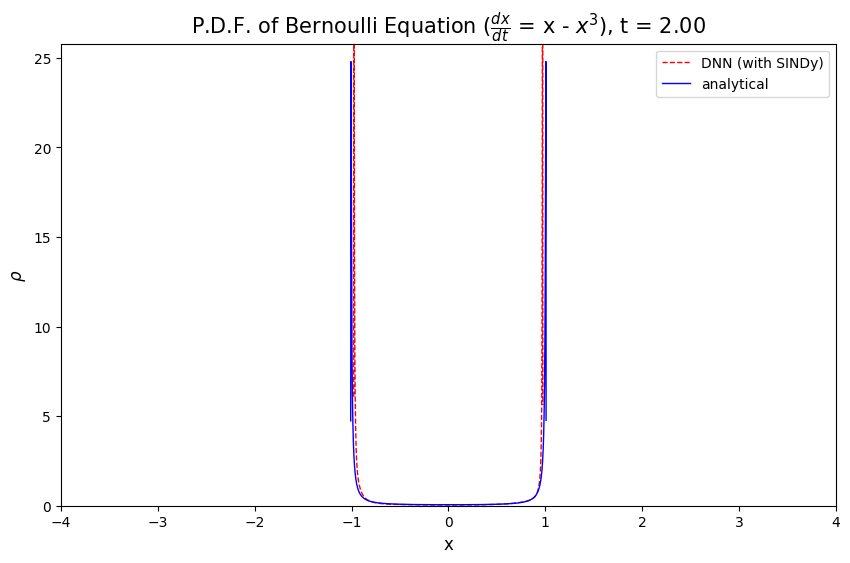

In [26]:
rho_ini = PDF(x_DNN[0, :], mu, sigma)

xx_ini, tt = np.meshgrid(x_DNN[0, :], t)
rhorho_ini, tt = np.meshgrid(rho_ini, t)

x_exact = xx_ini*np.exp(tt)*(1 - xx_ini**2 + (xx_ini**2)*np.exp(2*tt))**(-1/2)
rho_exact = rhorho_ini * (xx_ini - xx_ini**3) / (x_exact - x_exact**3)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xticks(np.linspace(-4, 4, 9))
ax.set_xlim([-4, 4])
ax.set_ylim([0, 2])
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel(r'$\rho$', fontsize=12)
ax.legend(loc='upper right', fontsize=10)

DNN_line, = ax.plot([], [], color='r', ls='--', lw=1, label='DNN (with SINDy)')
analytical_line, = ax.plot([], [], color='b', lw=1, label='analytical')
ax.legend(loc='upper right', fontsize=10)
#plt.tight_layout()

def init():
    DNN_line.set_data(x_DNN[0, :], rho_SINDy_DNN[0, :])
    analytical_line.set_data(x_exact[0, :], rho_exact[0, :])
    ax.set_title(r'P.D.F. of Bernoulli Equation ($\frac{dx}{dt}$ = x - $x^{3}$),'+' t = %.2f' %t[0], fontsize=15)
    return DNN_line, analytical_line

def update(frame):
    DNN_line.set_data(x_DNN[frame+1, :], rho_SINDy_DNN[frame+1, :])
    analytical_line.set_data(x_exact[frame+1, :], rho_exact[frame+1, :])
    if np.amax(rho_exact[frame+1, :]) >= 1:
        ax.set_ylim([0, np.amax(rho_exact[frame+1, :])+1])
    ax.set_title(r'P.D.F. of Bernoulli Equation ($\frac{dx}{dt}$ = x - $x^{3}$),'+' t = %.2f' %t[frame+1], fontsize=15)
    return DNN_line, analytical_line

ani = animation.FuncAnimation(fig, update, frames=nt-2, init_func=init, blit=True)

ani.save('Bernoulli_rho_DNN_SINDy (dt=%.2f).mp4' %h, fps=10, dpi=500)